Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# VISTA-2D Cell Segmentation with Segment Anything Model (SAM) & MONAI

![image](../figures/vista_2d_overview.png)

The tutorial demonstrates how to train a cell segmentation model using the [MONAI](https://monai.io/) framework and the [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) on the [Cellpose dataset](https://www.cellpose.org/).
In Summary the following steps are performed:
- Initialization of the CellSamWrapper model with pre-trained SAM weights
- Creation of data lists for training, validation, and testing
- Definition of data transforms for training and validation
- Setup of datasets and dataloaders with MONAI
- Implementation of the training loop, including:
    - Loss function (CellLoss)
    - Accuracy function (CellAcc)
    - Optimizer (SGD)
- Mixed precision training with GradScaler
- Sliding window inference via MONAI
- Visualization of training loss, validation loss, and validation accuracy
- Inference on a single validation image
- Visualization of input image, ground truth, and model prediction

The notebook demonstrates a complete pipeline for training and evaluating a cell segmentation model using the MONAI framework and the Segment Anything Model (SAM) on the Cellpose dataset. Please note we only use a small subset of the cellpose dataset for this tutorial.

For additional information about VISTA-2D please also refer the [MONAI bundle](https://github.com/Project-MONAI/VISTA/tree/main/vista2d) and the [technical blog post](https://developer.nvidia.com/blog/advancing-cell-segmentation-and-morphology-analysis-with-nvidia-ai-foundation-model-vista-2d/).

For dependency-related issues, you can also check this note:
https://github.com/Project-MONAI/model-zoo/tree/dev/models/vista2d#dependencies.
If you're using MONAI's container, you can disregard the 'opencv-python-headless not installed' error, as it is already included within the container.

## Check environment

In [ ]:
!nvidia-smi
!pip install -q fastremap
!pip install -q --no-deps cellpose
!pip install -q natsort
!pip install -q roifile

## Setup imports

In [21]:
import json
import os
import time
import shutil
import tempfile
import gc
from tqdm import tqdm
import tifffile
import random
import warnings
import matplotlib.pyplot as plt
import monai.transforms as mt
import numpy as np
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.inferers import SlidingWindowInfererAdapt
from monai.metrics import CumulativeAverage
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, LoadImaged, MapTransform
from monai.utils import ImageMetaKey
from monai.networks.nets.cell_sam_wrapper import CellSamWrapper
from torch.cuda.amp import GradScaler, autocast

from scripts.components import CellAcc, CellLoss, LabelsToFlows, LoadTiffd, LogitsToLabels

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08.02
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: 4.40.2
mlflow version: 2.16.0
pynrrd version: 1.0.0
clearml version: 1.16.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

Set the root_dir to the folder/volume that was mounted, containing the data files

In [28]:
root_dir = "/datasets/AZ_Workshop"

if not os.path.exists(os.path.join(root_dir,"data")):
    os.mkdir(os.path.join(root_dir,"data"))

zip_file_dir = "/datasets/AZ_Workshop/data/test"

'/workspace/data'

## Download dataset and Pre-trained weights

The Cellpose dataset needs to be downloaded from [this link](https://www.cellpose.org/).
The SAM weights need to be downloaded [from here](https://github.com/facebookresearch/segment-anything). The exact filename of weights that has been used for this tutorial is `sam_vit_b_01ec64.pth` 

In [3]:
data_list_path = os.path.join(root_dir, "cellpose_toy_datalist.json")
data_list_path_url = "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/cellpose_toy_datalist.json"
download_url(url=data_list_path_url, filepath=data_list_path)

sam_weights_path_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_weights_path = os.path.join(root_dir, "sam_vit_b_01ec64.pth")
download_url(url=sam_weights_path_url, filepath=sam_weights_path)

# TODO: Update this path to the location of the Cellpose dataset on your local machine
data_root = os.path.join(root_dir, "cellpose")

2025-02-20 18:15:14,801 - INFO - Expected md5 is None, skip md5 check for file /datasets/AZ_Workshop/data/cellpose_toy_datalist.json.
2025-02-20 18:15:14,802 - INFO - File exists: /datasets/AZ_Workshop/data/cellpose_toy_datalist.json, skipped downloading.
2025-02-20 18:15:14,803 - INFO - Expected md5 is None, skip md5 check for file /datasets/AZ_Workshop/data/sam_vit_b_01ec64.pth.
2025-02-20 18:15:14,804 - INFO - File exists: /datasets/AZ_Workshop/data/sam_vit_b_01ec64.pth, skipped downloading.


## Define the network, load SAM weights

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CellSamWrapper(checkpoint=sam_weights_path)
model.to(device)
print("SAM ViT-B weights loaded succesfully ...")

SAM ViT-B weights loaded succesfully ...


In [ ]:
# Create Required Data lists
# Append root path to training, validation and testing data list
with open(data_list_path, "r") as f:
    data = json.load(f)

validation_fold = 0
training_list = []
validation_list = []
testing_list = []

# Process training data
for item in data.get("training", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])

    training_list.append(item)

# Process testing data
i = 0
for item in data.get("testing", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])
    if i % 2==0:
        testing_list.append(item)
    else:
        validation_list.append(item)
    i+=1
        
print("Appended Data Root to Json file list ...")
print("Total Training Data: {}".format(len(training_list)))
print("Total Validation Data: {}".format(len(validation_list)))
print("Total Testing Data: {}".format(len(testing_list)))
#print(training_list)

## Training & Validation Transforms

In [ ]:
roi_size = [256, 256]
train_transforms = mt.Compose(
    [
        LoadTiffd(keys=["image", "label"]),
        mt.EnsureTyped(keys=["image", "label"], data_type="tensor", dtype=torch.float),
        mt.ScaleIntensityd(keys="image", minv=0, maxv=1, channel_wise=True),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.SpatialPadd(keys=["image", "label"], spatial_size=roi_size),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        mt.RandAffined(
            keys=["image", "label"],
            prob=0.5,
            rotate_range=np.pi,
            scale_range=[-0.5, 0.5],
            mode=["bilinear", "nearest"],
            spatial_size=roi_size,
            cache_grid=True,
            padding_mode="border",
        ),
        mt.RandAxisFlipd(keys=["image", "label"], prob=0.5),
        mt.RandGaussianNoised(keys=["image"], prob=0.25, mean=0, std=0.1),
        mt.RandAdjustContrastd(keys=["image"], prob=0.25, gamma=(1, 2)),
        mt.RandGaussianSmoothd(keys=["image"], prob=0.25, sigma_x=(1, 2)),
        mt.RandHistogramShiftd(keys=["image"], prob=0.25, num_control_points=3),
        mt.RandGaussianSharpend(keys=["image"], prob=0.25),
        LabelsToFlows(keys="label", flow_key="flow"),
    ]
)

val_transforms = mt.Compose(
    [
        LoadTiffd(keys=["image", "label"], allow_missing_keys=True),
        mt.EnsureTyped(
            keys=["image", "label"],
            data_type="tensor",
            dtype=torch.float,
            allow_missing_keys=True,
        ),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        LabelsToFlows(keys="label", flow_key="flow", allow_missing_keys=True),
    ]
)

# Datasets & Dataloaders for training, validation and testing
train_dataset = Dataset(data=training_list, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

val_dataset = Dataset(data=validation_list, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

# Training loop with validation
loss_function = CellLoss()
acc_function = CellAcc()

# Define the Sliding Window Inferer
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256], sw_batch_size=1, overlap=0.25, cache_roi_weight_map=True, progress=False
)

channels_last = True

if os.path.exists(data_root) is False:
    os.mkdir(data_root)
    
ckpt_path = os.path.join(data_root, "model_checkpoints")
if os.path.exists(ckpt_path) is False:
    os.mkdir(ckpt_path)
    
# To increase performance, more data would be needed,
# epochs can be increased for better results.
# Over-fitting is possible, hence please be careful with the number of epochs
# Differnet optimizers can be used as well for varying results.
# Please refer to VISTA-2D MONAI Bundle for more information.
max_epochs = 10

num_epochs_per_validation = 2

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

# Amp
scaler = GradScaler()
amp_dtype = torch.float16

best_ckpt_path = os.path.join(ckpt_path, "model.pt")
intermediate_ckpt_path = os.path.join(ckpt_path, "model_final.pt")

best_metric = -1
start_epoch = 0
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss_values = []
val_epoch_acc_values = []
for epoch in range(0, max_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0

    model.train()
    memory_format = torch.channels_last if channels_last else torch.preserve_format
    run_loss = CumulativeAverage()
    avg_loss = avg_acc = 0

    for idx, batch_data in enumerate(train_loader):
        data = batch_data["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)
        target = batch_data["flow"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast with float16 for mixed precision training
        with autocast(dtype=amp_dtype):
            logits = model(data)
            loss = loss_function(logits.float(), target)

        # Use the scaler for backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = data.shape[0]
        run_loss.append(loss, count=batch_size)
        avg_loss = run_loss.aggregate()

        print(f"Epoch {epoch}/{max_epochs} {idx}/{len(train_loader)} ")
        print(f"loss: {avg_loss:.4f} time {time.time() - start_time:.2f}s ")

    optimizer.zero_grad()

    epoch_loss_values.append(avg_loss)

    # Validation loop & model checkpoints
    if epoch % num_epochs_per_validation == 0:
        optimizer.zero_grad(set_to_none=True)
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            val_run_loss = CumulativeAverage()
            run_acc = CumulativeAverage()
            for val_idx, val_batch in enumerate(val_loader):
                v_data = val_batch["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

                target = val_batch["flow"].as_subclass(torch.Tensor).to(device=device)

                filename = val_batch["image"].meta[ImageMetaKey.FILENAME_OR_OBJ]
                batch_size = v_data.shape[0]
                loss = acc = None
                # Use autocast with float16 for mixed precision validation
                with autocast(dtype=amp_dtype):
                    logits = sliding_inferrer(inputs=v_data, network=model)
                    val_loss = loss_function(logits, target)

                val_run_loss.append(val_loss.to(device=device), count=batch_size)
                target = None

                pred_mask_all = []

                for b_ind in range(logits.shape[0]):  # go over batch dim
                    pred_mask = LogitsToLabels()(logits=logits[b_ind], filename=filename)
                    pred_mask_all.append(pred_mask)

                if acc_function is not None:
                    label = val_batch["label"].as_subclass(torch.Tensor)

                    for b_ind in range(label.shape[0]):
                        acc = acc_function(pred_mask_all[b_ind], label[b_ind, 0].long())
                        acc = acc.detach().clone() if isinstance(acc, torch.Tensor) else torch.tensor(acc)

                        run_acc.append(acc.to(device=device), count=1)
                    label = None

                avg_loss = val_loss.cpu() if val_loss is not None else 0
                avg_acc = acc.cpu().numpy() if acc is not None else 0

                print(f"Val {epoch}/{max_epochs} {val_idx}/{len(val_loader)} ")
                print(f"loss: {avg_loss:.4f} acc {avg_acc}  time {time.time() - start_time:.2f}s")

        val_epoch_loss_values.append(val_run_loss.aggregate())
        val_epoch_acc_values.append(run_acc.aggregate())
    # Model Saving & Checkpointing
    if avg_loss < best_metric:
        best_metric = avg_loss
        state_dict = model.state_dict()
        torch.save({"state_dict": state_dict}, best_ckpt_path)
        print(f"Model saved to {best_ckpt_path}")
print("Training Complete!")

## Loss plot visualization 

NameError: name 'max_epochs' is not defined

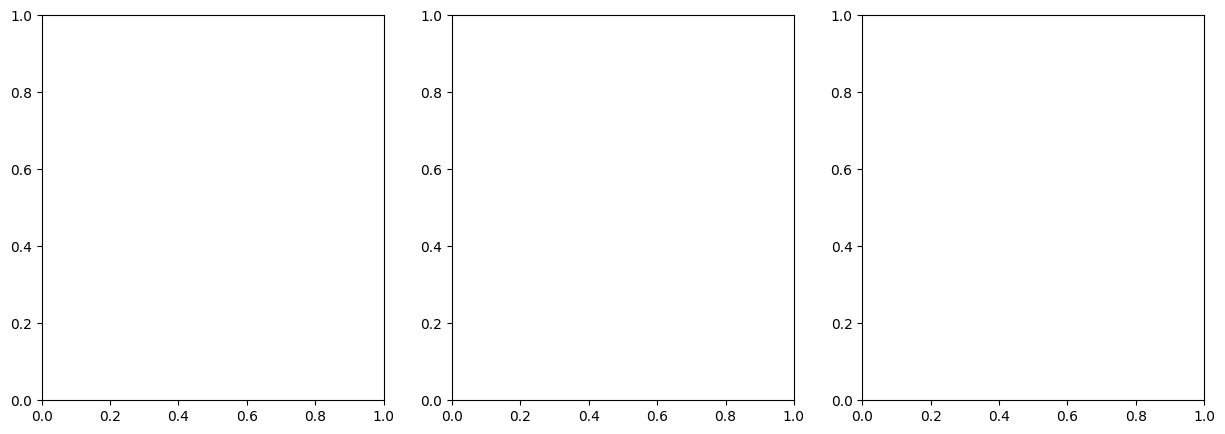

In [5]:
def show_metrics():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Loss
    axs[0].plot(range(0, max_epochs), epoch_loss_values, marker="o")
    axs[0].set_title("Training Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss Value")
    axs[0].grid(True)
    
    # Plot 2: Validation Loss
    axs[1].plot(val_epoch_loss_values, marker="o", color="orange")
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Validation Points")
    axs[1].set_ylabel("Val Loss Value")
    axs[1].grid(True)
    
    # Plot 3: Validation Accuracy
    axs[2].plot(val_epoch_acc_values, marker="x", color="green")
    axs[2].set_title("Validation Accuracy")
    axs[2].set_xlabel("Validation Points")
    axs[2].set_ylabel("Val Accuracy")
    axs[2].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

show_metrics()

## Define a transform to load and preprocess the image and visualize the results


(3, 256, 256)
(256, 256)
(256, 256)


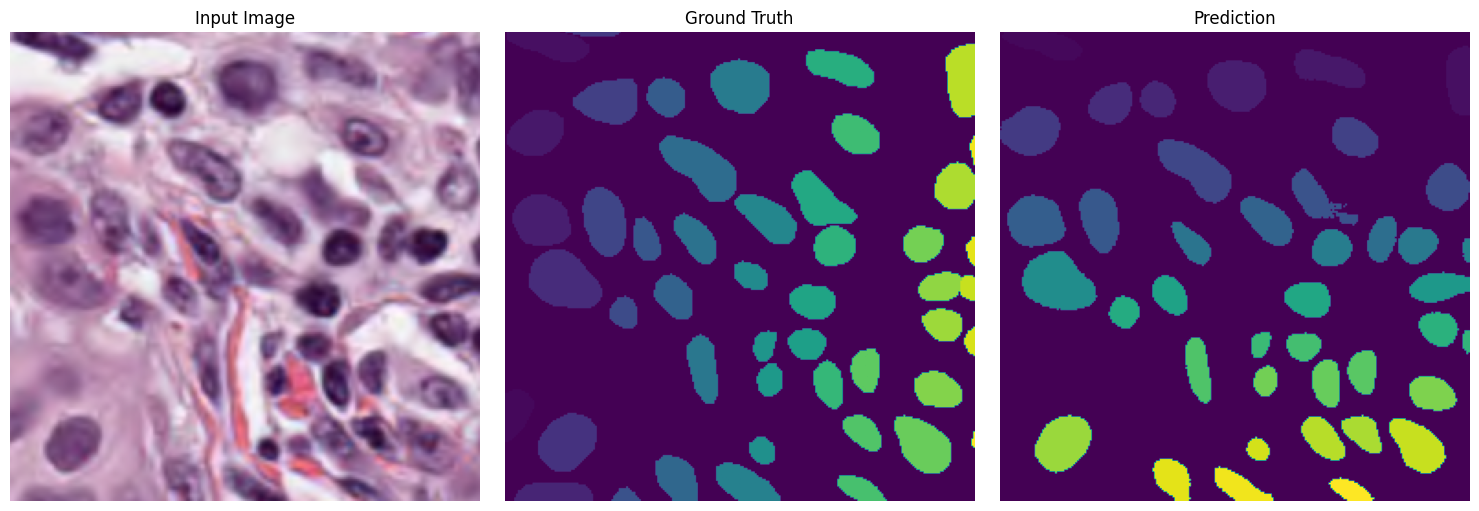

Image shape: (256, 256, 3)
Label shape: (256, 256)
Prediction shape: (256, 256)
Unique values in label: [0.         0.02083333 0.04166667 0.0625     0.08333334 0.10416666
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083334 0.29166666 0.3125     0.33333334 0.35416666
 0.375      0.39583334 0.41666666 0.4375     0.45833334 0.47916666
 0.5        0.5208333  0.5416667  0.5625     0.5833333  0.6041667
 0.625      0.6458333  0.6666667  0.6875     0.7083333  0.7291667
 0.75       0.7708333  0.7916667  0.8125     0.8333333  0.8541667
 0.875      0.8958333  0.9166667  0.9375     0.9583333  0.9791667
 1.        ]
Unique values in prediction: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 20 21 23 25 27 28
 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47]


In [27]:
warnings.filterwarnings('ignore')
preprocess = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

n_samples = len(Segmentation_Dataset['Test'])
random_number = random.randint(0, n_samples)
# Load a single validation image (index 2)
val_item = Segmentation_Dataset['Test'][random_number]
image_path = val_item["image"]
label_path = val_item["label"]

# Load and preprocess the image and label
image = preprocess(image_path)
label = preprocess(label_path)

# Ensure model is in eval mode and on the correct device
model.eval()
model.to(device)

# Perform inference
with torch.no_grad():
    input_tensor = torch.as_tensor(image).unsqueeze(0).to(device)
    with autocast(dtype=amp_dtype):
        logits = sliding_inferrer(inputs=input_tensor, network=model)

# Convert logits to prediction mask
pred_mask = LogitsToLabels()(logits=logits[0])

# Move tensors to CPU and convert to numpy for visualization
image = image.squeeze().cpu().numpy()
label = label.squeeze().cpu().numpy()

print(image.shape)
print(label.shape)
print(pred_mask.shape)
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Handle potential multi-channel images
if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
    image = np.transpose(image, (1, 2, 0))
    if image.shape[2] == 1:
        image = image[:, :, 0]

axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
axes[0].set_title("Input Image")
axes[0].axis("off")

if label.ndim == 3 and label.shape[0] == 1:
    label = label[0]
axes[1].imshow(label, cmap="viridis")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:
    pred_mask = pred_mask[0]
axes[2].imshow(pred_mask, cmap="viridis")
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Prediction shape: {pred_mask.shape}")
print(f"Unique values in label: {np.unique(label)}")
print(f"Unique values in prediction: {np.unique(pred_mask)}")

Now we will try fine-tuning using some more specialised datasets including IHC & H&E

The data come from the following public resources:

* TNBC 2018
* LynSeC
* IHC_TMA
* MoNuSeg
* PANNUKE

In [13]:
import requests
import zipfile
from tqdm import tqdm
from skimage import io
from scipy import ndimage
import fastremap
import skimage

Segmentation_Dataset = {}
Segmentation_Dataset['Train']=[]
Segmentation_Dataset['Test']=[]
Segmentation_Dataset['Validation']=[]

def download_and_extract(url, zip_dest_path, extract_to):
    if not os.path.exists(extract_to):
        os.mkdir(extract_to)

    if not os.path.exists(zip_dest_path):
        print(f"Downloading dataset from {url} to {zip_dest_path}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(zip_dest_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download completed.")
        
    print(f"Unzipping dataset to {extract_to}...")
    with zipfile.ZipFile(zip_dest_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(zip_dest_path)
    print("Unzipping completed.")

def add_item(image, labels, items, dataset, stain="H&E",licence="CC BY 4.0"):
    item = {}
    item['image']=image
    item['label']=labels #fastremap.refit(labels)
    item['fold']=0

    items.append(item)

    return items

def separate_touching_objects(lab):
    from scipy.ndimage import distance_transform_edt
    from skimage.segmentation import watershed
    from skimage.measure import label

    mask = lab > 0
    distance_map = distance_transform_edt(mask) 
    markers = distance_map > 2
    markers = label(markers)
    labels = watershed(-distance_map, markers, mask=mask)
    labels = labels + lab
    
    return labels

    
def show_data(item):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    temp_dataset = Dataset(data=item, transform=LoadImaged(keys=["image", "label"]))
    temp_loader = DataLoader(temp_dataset, batch_size=1, shuffle=False, num_workers=1)
    for idx, batch_data in enumerate(temp_loader):
        break
    
    image = np.uint8(batch_data['image'])
    label = batch_data['label']
    
    # Handle potential multi-channel 
    image = np.squeeze(image)
        
    if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
        image = np.transpose(image, (1, 2, 0))
        #if image.shape[2] == 1:
        #    image = image[:, :, 0]
    if image.ndim == 3 and image.shape[2]>3:
        image = image[:,:,:3]

    axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
    axes[0].set_title("Sample Image")
    axes[0].axis("off")
    
    #if label.ndim == 3 and label.shape[0] == 1:
    #    label = label[0]
    label = np.squeeze(label)
    if label.ndim == 3 and label.shape[0] in [1, 3, 4]:
        label = np.transpose(label, (1, 2, 0))

    if label.ndim == 3 and label.shape[2]>3:
        label = label[:,:,:3]
        
    axes[1].imshow(label)#, cmap="viridis")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

**TNBC**

100%|██████████| 29/29 [00:00<00:00, 44.71it/s]

68 items loaded


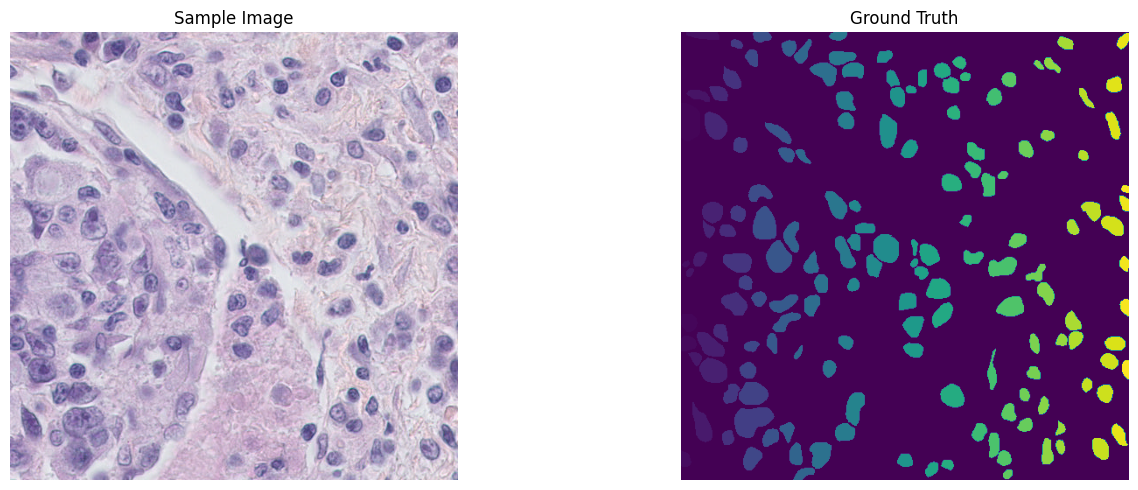

In [14]:
tnbc_dir = os.path.join(root_dir, "data", "TNBC_NucleiSegmentation")
zip_file_path = os.path.join(zip_file_dir , "TNBC_NucleiSegmentation.zip")
download_url = "https://zenodo.org/record/3552674/files/TNBC_and_Brain_dataset.zip?download=1"

if not os.path.exists(tnbc_dir):
    download_and_extract(download_url, zip_file_path, tnbc_dir)

file_path = tnbc_dir + "/TNBC_and_Brain_dataset"
folders = os.listdir(file_path)

items=[]

for i,folder in enumerate(tqdm(folders)):
    if "Slide_" in str(folder):
        for file in sorted(os.listdir(os.path.join(file_path,folder))):
            file = os.path.join(file_path,folder,file)
            if ".DS_Store" not in str(file):
                image = str(file)
                im_data = io.imread(image)
                if im_data.shape[2]>3:
                    im_data = im_data[:,:,:3]
                    io.imsave(str(file),im_data)     
                masks = str(file).replace("Slide_","GT_")
                if os.path.exists(masks):
                    mask_data = io.imread(masks)
                    # print(np.unique(mask_data))
                    mask_data = separate_touching_objects(mask_data)
                    mask_data, remapping = fastremap.renumber(mask_data, in_place=True)
                    mask_data = fastremap.refit(mask_data)
                    os.remove(masks)
                    masks = masks.replace(".png",".npy")
                    np.save(masks,mask_data.T)
                else:
                    masks = masks.replace(".png",".npy")
                    
                items = add_item(image, masks, items, "TNBC_2018")

np.random.seed(42) 
np.random.shuffle(items)
print("{} items loaded".format(len(items)))
Segmentation_Dataset['Train']+=items[:int(len(items)*0.8)]
Segmentation_Dataset['Validation']+=items[int(len(items)*0.8):int(len(items)*0.9)]
Segmentation_Dataset['Test']+=items[int(len(items)*0.9):]

show_data(items)

**LyNSec**

Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/LyNSeC...
Unzipping completed.


100%|██████████| 3/3 [00:34<00:00, 11.56s/it]

419 items added
419 items loaded


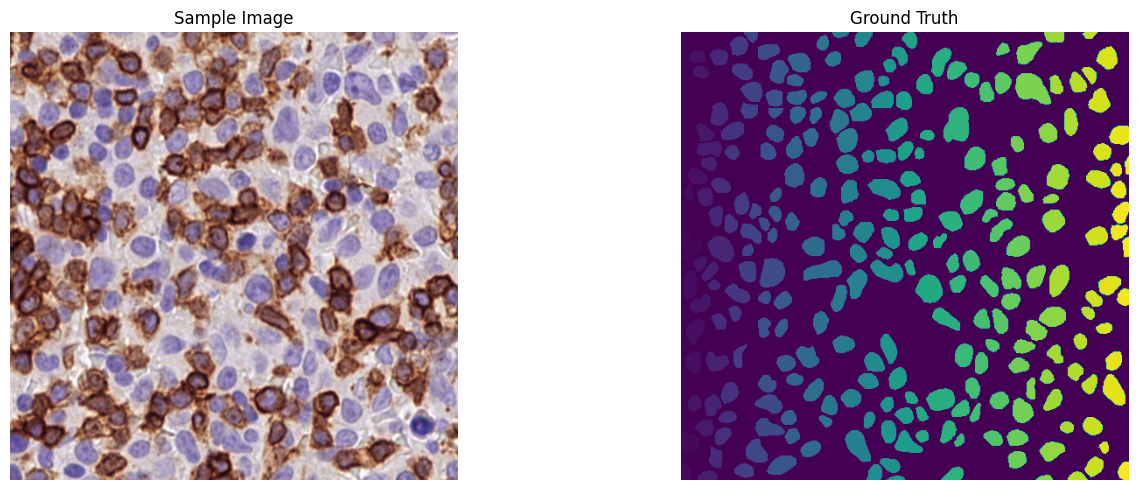

In [15]:
lynsec_dir = "/datasets/AZ_Workshop/data/LyNSeC"
zip_file_path = lynsec_dir + "/LyNSeC.zip"
download_url = "https://zenodo.org/record/8065174/files/lynsec.zip?download=1"

if not os.path.exists(lynsec_dir):
    download_and_extract(download_url, zip_file_path, lynsec_dir)
    
file_path = lynsec_dir
folders = os.listdir(file_path)

items = []

for i, folder in enumerate(tqdm(folders)):
    if folder[:8] == "lynsec 2":  # Skip incorrectly annotated folder
        #print("skip")
        continue


    for j, file in enumerate(sorted(os.listdir(os.path.join(file_path,folder)))):
        file_ =os.path.join(file_path,folder,file)
        if ".DS_Store" not in str(file_) and "_lbl" not in str(file_):
            mask_file = str(file_)
            image_file = mask_file.replace(".npy",".png")
            if not os.path.exists(image_file):
                data = np.load(str(file_))
                np.save(mask_file, data[:, :, 3].T)
                io.imsave(image_file,data[:, :, :3].astype(np.uint8))
            items = add_item(image_file, mask_file, items, "LyNSeC")

np.random.seed(42) 
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]
Segmentation_Dataset['Test'] += items[int(len(items) * 0.9):]

print("{} items loaded".format(len(items)))

show_data(items)

**IHC TMA**

Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/IHC_TMA_dataset...
Unzipping completed.


100%|██████████| 266/266 [00:03<00:00, 77.61it/s]

266 items added


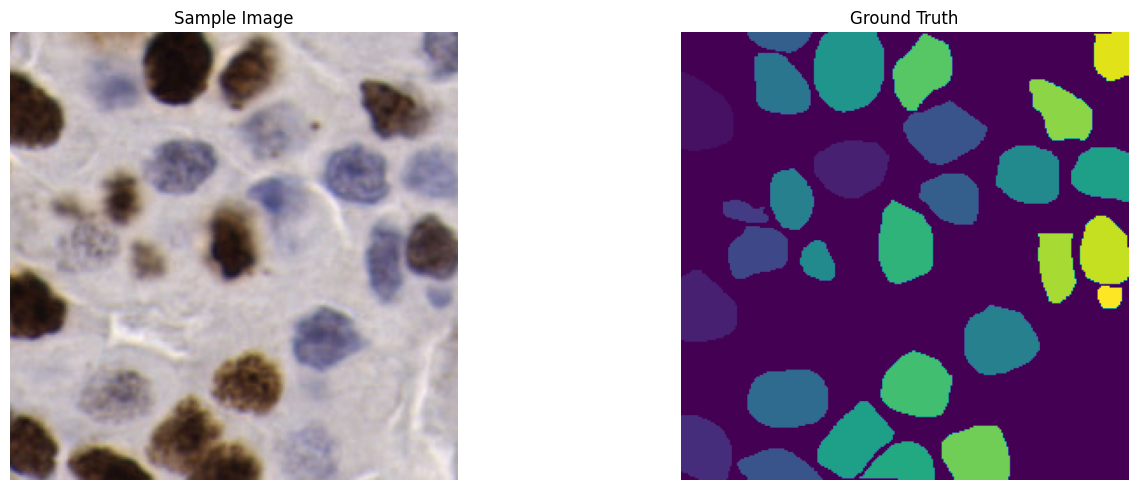

In [16]:
ihc_tma_dir = "/datasets/AZ_Workshop/data/IHC_TMA_dataset"
zip_file_path = ihc_tma_dir + "/IHC_TMA_dataset.zip"
download_url = "https://zenodo.org/record/7647846/files/IHC_TMA_dataset.zip?download=1"

if not os.path.exists(ihc_tma_dir):
    download_and_extract(download_url, zip_file_path, ihc_tma_dir)
    
file_path = ihc_tma_dir + "/IHC_TMA_dataset/images"
files = sorted(os.listdir(file_path))

items = []

for i, file in enumerate(tqdm(files)):
    image =os.path.join(file_path,file)
    
    mask_path = str(os.path.join(file_path,file)).replace("images", "masks").replace(".png", ".npy")
    masks = np.load(mask_path)
    if masks.shape!=(256,256):
        n_masks = np.max(masks[0:2], axis=0)
    
        masks = separate_touching_objects(n_masks)
        masks, remapping = fastremap.renumber(masks, in_place=True)
        masks = fastremap.refit(masks)
        
        np.save(mask_path,masks.T)
        
    items = add_item(image, mask_path, items, "IHC_TMA","IHC")

np.random.seed(42)
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]
Segmentation_Dataset['Test'] += items[int(len(items) * 0.9):]

show_data(items)


**MoNuSeg**

Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/MoNuSeg...
Unzipping completed.


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]

30 items added


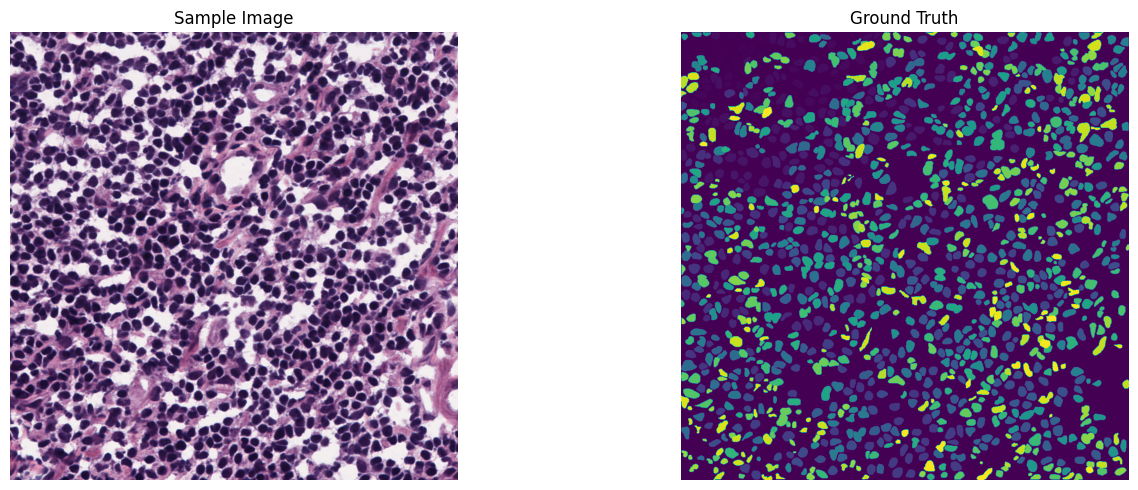

In [17]:
monuseg_dir = "/datasets/AZ_Workshop/data/MoNuSeg"
zip_file_path = monuseg_dir + "/MoNuSeg.zip"
download_url = "https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/monuseg-2018.zip"

if not os.path.exists(monuseg_dir):
    download_and_extract(download_url, zip_file_path, monuseg_dir)
    
file_path = os.path.join(monuseg_dir,"monuseg-2018/download")

# Process Test Data
items = []
set_type = "test"
test_files = os.listdir(os.path.join(file_path,set_type,"images"))

for file in tqdm(test_files):
    if ".DS_Store" not in str(file):
        image = os.path.join(file_path,set_type,"images",file)
        masks = str(image).replace("images", "masks")
        if ".tif" in image:
            im = io.imread(image)
            os.remove(image)
            image = image.replace(".tif",".png")
            io.imsave(image,im[:,:,:3])
            mk = io.imread(masks)
            os.remove(masks)
            masks = masks.replace(".tif",".npz")
            np.savez_compressed(masks,mk.T)
        else:
            masks = masks.replace(".png",".npz")
        
        items = add_item(image, masks, items, "MoNuSeg")
        
Segmentation_Dataset['Test'] += items[:int(len(items) * 0.5)]
Segmentation_Dataset['Validation'] += items[:int(len(items) * 0.5)]

# Process Train Data
items = []
set_type = "train"
train_files = os.listdir(os.path.join(file_path,set_type,"images"))

for file in tqdm(train_files):
    if ".DS_Store" not in str(file):
        image = os.path.join(file_path,set_type,"images",file)
        masks = str(image).replace("images", "masks")
        if ".tif" in image:
            im = io.imread(image)
            os.remove(image)
            image = image.replace(".tif",".png")
            io.imsave(image,im[:,:,:3])
            mk = io.imread(masks)
            os.remove(masks)
            masks = masks.replace(".tif",".npz")
            np.savez_compressed(masks,mk.T)
        else:
            masks = masks.replace(".png",".npz")
        
        items = add_item(image, masks, items, "MoNuSeg")

np.random.seed(42)
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]

show_data(items)

**PANNUKE**

In [18]:

pannuke_dir = "/datasets/AZ_Workshop/data/PanNuke"

for fold in ["1", "2", "3"]:
    if not os.path.exists(os.path.join(pannuke_dir, "Fold {}".format(fold))):
        if not os.path.exists(os.path.join(pannuke_dir, "fold_{}.zip".format(fold))):
            zip_file_path = os.path.join(pannuke_dir, "fold_{}.zip".format(fold))
            download_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_{}.zip".format(fold)
    
            # Download and unzip the dataset
            download_and_extract(download_url, zip_file_path, pannuke_dir)


Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/PanNuke...
Unzipping completed.
Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/PanNuke...
Unzipping completed.
Download completed.
Unzipping dataset to /datasets/AZ_Workshop/data/PanNuke...
Unzipping completed.


 61%|██████    | 1615/2656 [00:56<00:29, 35.36it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1617.png is a low contrast image

 65%|██████▍   | 1721/2656 [01:00<00:28, 32.86it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1723.png is a low contrast image

 71%|███████   | 1889/2656 [01:05<00:28, 27.09it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1890.png is a low contrast image

 72%|███████▏  | 1921/2656 [01:07<00:29, 25.12it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1923.png is a low contrast image

 73%|███████▎  | 1937/2656 [01:07<00:26, 27.07it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1939.png is a low contrast image

 73%|███████▎  | 1940/2656 [01:07<00:26, 27.53it/s]WARNING:py.warnings:/datasets/AZ_Workshop/data/PanNuke/all_images/train/image_1940.png is a low contrast image

 73%|███████▎  | 1944/

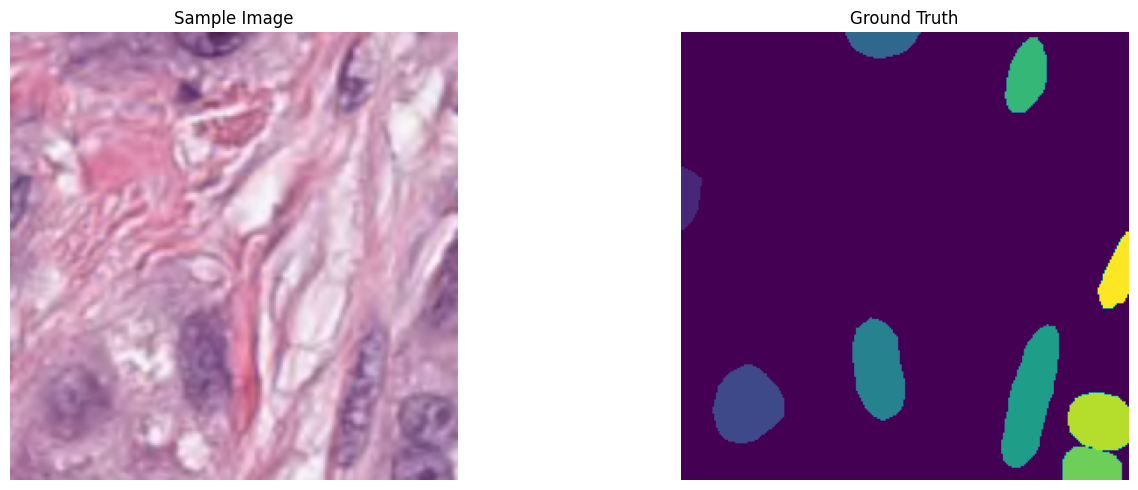

In [19]:
warnings.filterwarnings('ignore')

def get_data(dataset):

    if dataset == "train":
        fold = "1"
    elif dataset == "val":
        fold = "2"
    elif dataset == "test":
        fold = "3"

    create_files=False
    out_path = os.path.join(pannuke_dir,"all_images")
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        create_files=True
    out_path = os.path.join(out_path,dataset)
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        create_files=True

    items = []
    masks = np.load(os.path.join(pannuke_dir,"Fold {}/masks/fold{}/masks.npy".format(fold,fold)), allow_pickle = True).astype(np.int16)
    images = np.load(os.path.join(pannuke_dir,"Fold {}/images/fold{}/images.npy".format(fold,fold)), allow_pickle = True).astype(np.uint8)

    for i in tqdm(range(len(images))):

        assert (np.unique(masks[i,:,:,:-1]) == np.unique(masks[i,:,:,:-1].max(-1))).all()
        label = masks[i,:,:,:-1].max(-1)
        label,_ = fastremap.renumber(label, in_place=True)
        classes = (np.argmax(masks[i,:,:,:-1],axis = -1) + 1) * (label > 0).astype(np.int8)

        image = images[i]
        relative_path_img = os.path.join(out_path , "image_"+str(i)+".png")
        relative_path_nucleus =os.path.join(out_path , "nucleus_masks_"+str(i)+".npz")
        if create_files:
            io.imsave(relative_path_img,image)
            np.savez_compressed(relative_path_nucleus, label.T)

        items = add_item(relative_path_img, relative_path_nucleus, items, "PanNuke")
        if fold==1:
            print("{} items added".format(len(items)))

    return items
items = get_data("train")
Segmentation_Dataset['Train']+=items
items = get_data("val")
Segmentation_Dataset['Validation']+items
Segmentation_Dataset['Test']+=get_data("test")

show_data(items)

In [ ]:
warnings.filterwarnings('ignore')

class PrintInputsTransform(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                print(f"Input for key '{key}':")
                print(data[key].shape)
            else:
                print(f"Key '{key}' not found in input data")
        return data

roi_size = [256, 256]
train_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=False),
        #PrintInputsTransform(keys=["image","label"]),
        mt.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 0.0)),
        mt.EnsureTyped(keys=["image", "label"], data_type="tensor", dtype=torch.float),
        mt.ScaleIntensityd(keys="image", minv=0, maxv=1, channel_wise=True),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.SpatialPadd(keys=["image", "label"], spatial_size=roi_size),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        mt.RandAffined(
            keys=["image", "label"],
            prob=0.5,
            rotate_range=np.pi,
            scale_range=[-0.5, 0.5],
            mode=["bilinear", "nearest"],
            spatial_size=roi_size,
            cache_grid=True,
            padding_mode="border",
        ),
        mt.RandAxisFlipd(keys=["image", "label"], prob=0.5),
        mt.RandGaussianNoised(keys=["image"], prob=0.25, mean=0, std=0.1),
        mt.RandAdjustContrastd(keys=["image"], prob=0.25, gamma=(1, 2)),
        mt.RandGaussianSmoothd(keys=["image"], prob=0.25, sigma_x=(1, 2)),
        mt.RandHistogramShiftd(keys=["image"], prob=0.25, num_control_points=3),
        mt.RandGaussianSharpend(keys=["image"], prob=0.25),
        #PrintInputsTransform(keys="label"),
        LabelsToFlows(keys="label", flow_key="flow"),
    ]
)

val_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=False),
        mt.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 0.0)),
        mt.EnsureTyped(
            keys=["image", "label"],
            data_type="tensor",
            dtype=torch.float,
            allow_missing_keys=True,
        ),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        LabelsToFlows(keys="label", flow_key="flow", allow_missing_keys=True),
    ]
)

# Datasets & Dataloaders for training, validation and testing
train_dataset = Dataset(data=Segmentation_Dataset['Train'], transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True, shuffle=True, num_workers=1)

val_dataset = Dataset(data=Segmentation_Dataset['Validation'], transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1)

# Training loop with validation
loss_function = CellLoss()
acc_function = CellAcc()

# Define the Sliding Window Inferer
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256], sw_batch_size=1, overlap=0.25, cache_roi_weight_map=True, progress=False
)

channels_last = True

if os.path.exists(data_root) is False:
    os.mkdir(data_root)
    
ckpt_path = os.path.join(data_root, "model_checkpoints")
if os.path.exists(ckpt_path) is False:
    os.mkdir(ckpt_path)
    
# To increase performance, more data would be needed,
# epochs can be increased for better results.
# Over-fitting is possible, hence please be careful with the number of epochs
# Differnet optimizers can be used as well for varying results.
# Please refer to VISTA-2D MONAI Bundle for more information.
max_epochs = 5
num_epochs_per_validation = 1

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

# Amp
scaler = GradScaler()
amp_dtype = torch.float16

best_ckpt_path = os.path.join(ckpt_path, "model.pt")
intermediate_ckpt_path = os.path.join(ckpt_path, "model_final.pt")

best_metric = -1
start_epoch = 0
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss_values = []
val_epoch_acc_values = []
for epoch in range(0, max_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0

    model.train()
    memory_format = torch.channels_last if channels_last else torch.preserve_format
    run_loss = CumulativeAverage()
    avg_loss = avg_acc = 0

    for idx, batch_data in enumerate(train_loader):

        data = batch_data["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        target = batch_data["flow"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast with float16 for mixed precision training
        with autocast(dtype=amp_dtype):
            logits = model(data)
            loss = loss_function(logits.float(), target)

        # Use the scaler for backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = data.shape[0]
        run_loss.append(loss, count=batch_size)
        avg_loss = run_loss.aggregate()

        if idx % 10==0:
            print(f"Epoch {epoch}/{max_epochs} {idx}/{len(train_loader)} ")
            print(f"loss: {avg_loss:.4f} time {time.time() - start_time:.2f}s ")

    optimizer.zero_grad()

    epoch_loss_values.append(avg_loss)

    # Validation loop & model checkpoints
    if epoch % num_epochs_per_validation == 0:
        optimizer.zero_grad(set_to_none=True)
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            val_run_loss = CumulativeAverage()
            run_acc = CumulativeAverage()
            for val_idx, val_batch in enumerate(val_loader):
                v_data = val_batch["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

                target = val_batch["flow"].as_subclass(torch.Tensor).to(device=device)

                filename = val_batch["image"].meta[ImageMetaKey.FILENAME_OR_OBJ]
                batch_size = v_data.shape[0]
                loss = acc = None
                # Use autocast with float16 for mixed precision validation
                with autocast(dtype=amp_dtype):
                    logits = sliding_inferrer(inputs=v_data, network=model)
                    #if epoch==0:
                    #    torch.save(logits,"/datasets/AZ_Workshop/data/logits.pt")
                    #    torch.save(target,"/datasets/AZ_Workshop/data/target.pt")
                    val_loss = loss_function(logits, target)

                val_run_loss.append(val_loss.to(device=device), count=batch_size)
                target = None

                pred_mask_all = []

                for b_ind in range(logits.shape[0]):  # go over batch dim
                    pred_mask = LogitsToLabels()(logits=logits[b_ind], filename=filename)
                    pred_mask_all.append(pred_mask)

                if acc_function is not None:
                    label = val_batch["label"].as_subclass(torch.Tensor)

                    for b_ind in range(label.shape[0]):
                        acc = acc_function(pred_mask_all[b_ind], label[b_ind, 0].long())
                        acc = acc.detach().clone() if isinstance(acc, torch.Tensor) else torch.tensor(acc)

                        run_acc.append(acc.to(device=device), count=1)
                    label = None

                avg_loss = val_loss.cpu() if val_loss is not None else 0
                avg_acc = acc.cpu().numpy() if acc is not None else 0

                #print(f"Val {epoch}/{max_epochs} {val_idx}/{len(val_loader)} ")
            print(f"Val loss: {val_run_loss.aggregate():.4f} acc {run_acc.aggregate()}  time {time.time() - start_time:.2f}s")

        val_epoch_loss_values.append(val_run_loss.aggregate())
        val_epoch_acc_values.append(run_acc.aggregate())
    # Model Saving & Checkpointing
    if avg_loss < best_metric:
        best_metric = avg_loss
        state_dict = model.state_dict()
        torch.save({"state_dict": state_dict}, best_ckpt_path)
        print(f"Model saved to {best_ckpt_path}")
print("Training Complete!")

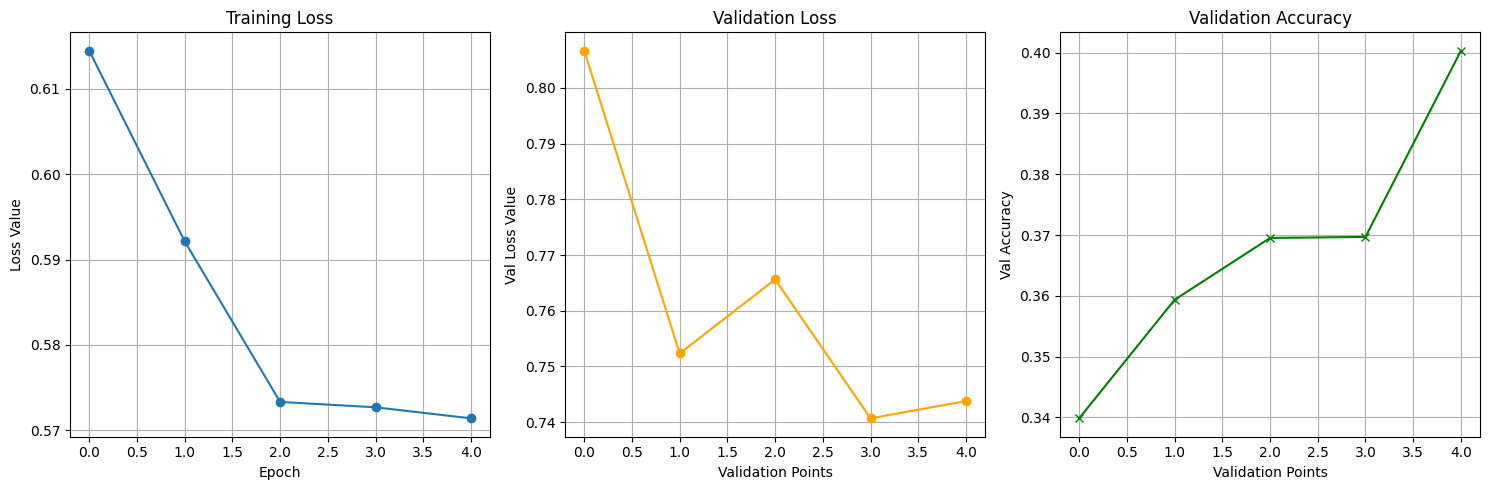

In [25]:
show_metrics()

In [ ]:
if os.path.exists("/datasets/AZ_Workshop/data/logits.pt"):
    logits = torch.load("/datasets/AZ_Workshop/data/logits.pt")
    target = torch.load("/datasets/AZ_Workshop/data/target.pt")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Handle potential multi-channel 
    image = np.squeeze(logits[0].cpu().numpy())
    label = np.squeeze(target[0].cpu().numpy())
    
    if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
        image = np.transpose(image, (1, 2, 0))
    
        
    axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
    axes[0].set_title("Sample Image")
    axes[0].axis("off")
    
    label = np.squeeze(label)
    if label.ndim == 3 and label.shape[0] in [1, 3, 4]:
        label = np.transpose(label, (1, 2, 0))
    
    if label.ndim == 3 and label.shape[2]>3:
        label = label[:,:,:3]
        
    axes[1].imshow(label)#, cmap="viridis")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No outputs to show")